In [1]:
#! pip install scikeras
#! pip install matplotlib
#!pip install seaborn

import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import plot_model
import seaborn as sns

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
Train = pd.read_csv("USCensusTraining.csv", na_values=[" ?","?","? "])
Train['income'] = Train['income'].map({'>50K.':1,'<=50K.':0})
Train = Train.drop(columns=['education'])  # drop 'education-num' as it's redundant with 'education'
Train = Train[Train['native-country'] != 'Holand-Netherlands']

cat_cols = Train.select_dtypes(exclude=['number']).columns.tolist()

for col in cat_cols:
    dominant_value = Train[col].mode()[0]
    Train[col] = Train[col].fillna(dominant_value)

X_t = Train.drop(columns=["income"])
y_t = Train["income"]

X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

# 3) Column types


numcol = X_train.select_dtypes(include=['number']).columns
catcol = X_train.select_dtypes(exclude=['number']).columns


# 4) Preprocess: impute+scale numeric, impute+onehot categorical
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", preprocessing.MinMaxScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # use sparse=False if needed
])


preprocessor = ColumnTransformer(
    transformers= [
        ("num", numeric_pipe, numcol),
        ("cat", categorical_pipe, catcol)
    ], remainder="drop"
)

X_train_prepared = preprocessor.fit_transform(X_train) #learn and transform
X_test_prepared  = preprocessor.transform(X_test) #only transform

X_prepared = preprocessor.transform(Train)
pd.DataFrame(X_train_prepared).describe()
#pd.DataFrame(X_test_prepared).describe()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.0000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,0.296048,0.119085,0.605340,0.010589,0.020749,0.401338,0.029551,0.065453,0.0001,0.750638,...,0.001200,0.003750,0.000300,0.002450,0.001550,0.000500,0.000550,0.914146,0.002250,0.000450
std,0.187472,0.073387,0.170450,0.073525,0.093830,0.124940,0.169351,0.247330,0.0100,0.432655,...,0.034622,0.061125,0.017319,0.049439,0.039341,0.022356,0.023447,0.280156,0.047383,0.021209
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.068941,0.533333,0.000000,0.000000,0.397959,0.000000,0.000000,0.0000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.273973,0.111131,0.600000,0.000000,0.000000,0.397959,0.000000,0.000000,0.0000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.424658,0.151877,0.733333,0.000000,0.000000,0.448980,0.000000,0.000000,0.0000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
def build_model(optimizer="RMSprop", lr=0.001, units=32, act="sigmoid"):
    model = Sequential(name="ANN_Tunable")
    model.add(Input(shape=(X_train_prepared.shape[1],), name="input_features")) 
    model.add(Dense(units, activation=act, kernel_initializer="glorot_uniform", name="hidden"))
    model.add(Dense(1, activation="sigmoid", name="output"))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == "rmsprop":
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt,loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
clf = KerasClassifier(model=build_model, epochs=40, batch_size=32, verbose=2, random_state=42) #the purpose of this line is to wrap the Keras model so it can be used by scikit-learn
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd"],
    "model__lr": [0.01, 0.001],
    "model__act": ["relu","sigmoid"],
    "epochs": [20],
    "batch_size": [32]   
}

Grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=3, scoring="accuracy", verbose=2)


In [6]:
Grid_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Epoch 1/20
625/625 - 5s - 7ms/step - accuracy: 0.8192 - loss: 0.3732
Epoch 2/20
625/625 - 2s - 4ms/step - accuracy: 0.8394 - loss: 0.3414
Epoch 3/20
625/625 - 2s - 4ms/step - accuracy: 0.8448 - loss: 0.3330
Epoch 4/20
625/625 - 2s - 4ms/step - accuracy: 0.8472 - loss: 0.3291
Epoch 5/20
625/625 - 3s - 4ms/step - accuracy: 0.8476 - loss: 0.3270
Epoch 6/20
625/625 - 3s - 4ms/step - accuracy: 0.8481 - loss: 0.3257
Epoch 7/20
625/625 - 3s - 4ms/step - accuracy: 0.8487 - loss: 0.3246
Epoch 8/20
625/625 - 3s - 4ms/step - accuracy: 0.8490 - loss: 0.3236
Epoch 9/20
625/625 - 3s - 4ms/step - accuracy: 0.8489 - loss: 0.3227
Epoch 10/20
625/625 - 2s - 3ms/step - accuracy: 0.8494 - loss: 0.3217
Epoch 11/20
625/625 - 3s - 4ms/step - accuracy: 0.8503 - loss: 0.3208
Epoch 12/20
625/625 - 3s - 4ms/step - accuracy: 0.8509 - loss: 0.3199
Epoch 13/20
625/625 - 3s - 4ms/step - accuracy: 0.8517 - loss: 0.3190
Epoch 14/20
625/625 - 3s - 4ms/step - 

,estimator,KerasClassifi..._weight=None )
,param_grid,"{'batch_size': [32], 'epochs': [20], 'model__act': ['relu', 'sigmoid'], 'model__lr': [0.01, 0.001], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...001D906A8EB60>


In [7]:
print("Best params:", Grid_search.best_params_)
print("Best CV accuracy", Grid_search.best_score_)

Best params: {'batch_size': 32, 'epochs': 20, 'model__act': 'sigmoid', 'model__lr': 0.01, 'model__optimizer': 'RMSprop', 'model__units': 16}
Best CV accuracy 0.8513428964015346


In [8]:
# type(X_train_prepared),getattr(X_train_prepared, "dtype", None)
# getattr(y_train, "dtype", None)
# y_train

In [20]:
model = build_model(optimizer="RMSprop", lr=0.01, units=16, act="sigmoid")
history = model.fit(X_train_prepared, y_train, epochs=20, batch_size=32, validation_split=0.2,verbose=2)

y_train_prob = model.predict(X_train_prepared)
y_test_prob = model.predict(X_test_prepared)

# y_train_pred = [round(y[0]) for y in y_train_prob]
# y_test_pred = [round(y[0]) for y in y_test_prob]

y_test_pred = (y_test_prob >= 0.5).astype(int)
y_train_pred = (y_train_prob >= 0.5).astype(int)

Epoch 1/20
500/500 - 3s - 6ms/step - accuracy: 0.8169 - loss: 0.3776 - val_accuracy: 0.8378 - val_loss: 0.3421
Epoch 2/20
500/500 - 1s - 2ms/step - accuracy: 0.8343 - loss: 0.3480 - val_accuracy: 0.8508 - val_loss: 0.3274
Epoch 3/20
500/500 - 1s - 2ms/step - accuracy: 0.8403 - loss: 0.3390 - val_accuracy: 0.8553 - val_loss: 0.3215
Epoch 4/20
500/500 - 1s - 2ms/step - accuracy: 0.8425 - loss: 0.3347 - val_accuracy: 0.8562 - val_loss: 0.3189
Epoch 5/20
500/500 - 1s - 2ms/step - accuracy: 0.8440 - loss: 0.3320 - val_accuracy: 0.8562 - val_loss: 0.3173
Epoch 6/20
500/500 - 1s - 2ms/step - accuracy: 0.8454 - loss: 0.3300 - val_accuracy: 0.8555 - val_loss: 0.3161
Epoch 7/20
500/500 - 1s - 2ms/step - accuracy: 0.8459 - loss: 0.3284 - val_accuracy: 0.8550 - val_loss: 0.3153
Epoch 8/20
500/500 - 1s - 2ms/step - accuracy: 0.8454 - loss: 0.3271 - val_accuracy: 0.8545 - val_loss: 0.3148
Epoch 9/20
500/500 - 1s - 2ms/step - accuracy: 0.8460 - loss: 0.3261 - val_accuracy: 0.8530 - val_loss: 0.3144
E

In [21]:
print("=== Training Data ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test data
print("=== Test Data ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

=== Training Data ===
Accuracy: 0.8523426171308566
Confusion Matrix:
 [[14498   749]
 [ 2204  2548]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     15247
           1       0.77      0.54      0.63      4752

    accuracy                           0.85     19999
   macro avg       0.82      0.74      0.77     19999
weighted avg       0.85      0.85      0.84     19999

=== Test Data ===
Accuracy: 0.8504
Confusion Matrix:
 [[3604  164]
 [ 584  648]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91      3768
           1       0.80      0.53      0.63      1232

    accuracy                           0.85      5000
   macro avg       0.83      0.74      0.77      5000
weighted avg       0.85      0.85      0.84      5000



In [22]:
model.summary()


Model: "ANN_Tunable"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 16)             │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,884 (11.27 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,443 (5.64 KB)

In [12]:
from sklearn.inspection import permutation_importance

In [13]:
X_test_copy = X_test.copy()                 # BEFORE transform


X_test_combine = X_test_copy.assign(predicted_income=y_test_pred)
X_test_combine.head()
#y_test_pred
#print(X_test_combine["predicted_income"].dtype) 

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predicted_income
6868,32,Private,128016,9,Married-spouse-absent,Other-service,Unmarried,White,Female,0,0,20,United-States,0
19678,41,Private,70092,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,38,United-States,0
9668,31,Private,382368,7,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
13640,46,Local-gov,162566,14,Divorced,Prof-specialty,Unmarried,White,Female,0,0,50,Canada,0
14018,17,Private,331552,8,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0


In [14]:
best = Grid_search.best_estimator_
y_test_vec = y_test.astype(int).to_numpy()

ohe_result = permutation_importance(best, X_test_prepared, y_test_vec, n_repeats=2, random_state=42, n_jobs=-1, scoring='accuracy')
ohe_imp = (pd.DataFrame({
        "feature": preprocessor.get_feature_names_out(),
        "importance_mean": ohe_result.importances_mean,
        "importance_std": ohe_result.importances_std # standard deviation of importance
        })
        .sort_values("importance_mean", ascending=False))

#print(imp_orig.head(15))

157/157 - 1s - 4ms/step


In [15]:
ohe_imp["orig_feature"] = ohe_imp["feature"].apply(
    lambda x: x.split("__")[1].split("_")[0]  # from cat__marital-status_Divorced → marital-status
)

ohe_imp["importance_mean"] = ohe_imp["importance_mean"].abs()

importance = (
    ohe_imp.groupby("orig_feature")["importance_mean"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

importance

,orig_feature,importance_mean
0,marital-status,0.3529
1,occupation,0.2070
2,relationship,0.1670
3,education-num,0.0430
4,capital-gain,0.0288
5,race,0.0116
6,hours-per-week,0.0088
7,age,0.0072
8,native-country,0.0057
9,sex,0.0042


In [16]:
print(importance.tail(5))

      orig_feature  importance_mean
8   native-country           0.0057
9              sex           0.0042
10       workclass           0.0041
11    capital-loss           0.0031
12     demogweight           0.0009


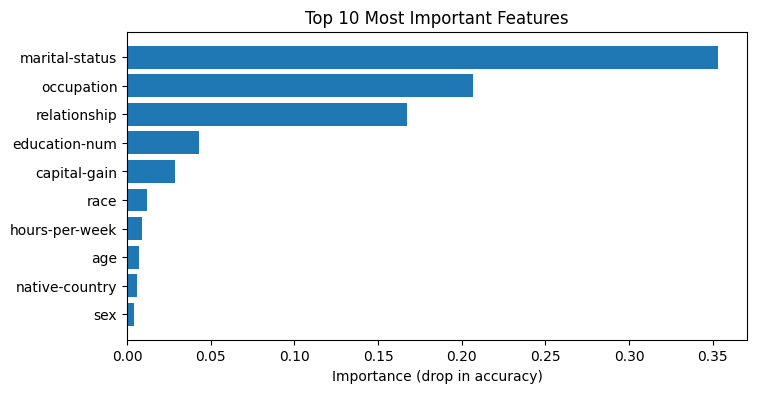

In [17]:
top = importance.head(10)
plt.figure(figsize=(8,4))
plt.barh(top['orig_feature'], top['importance_mean'])
plt.xlabel("Importance (drop in accuracy)")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()
plt.show()

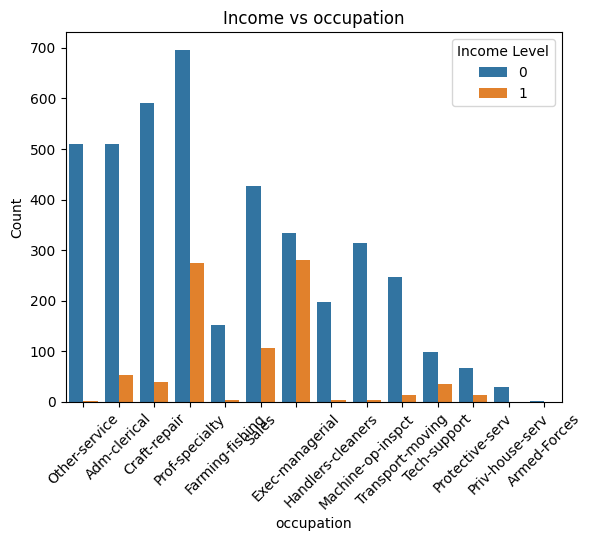

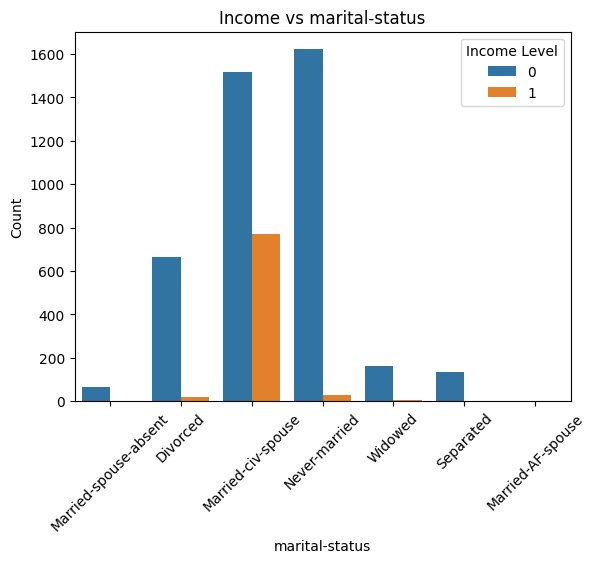

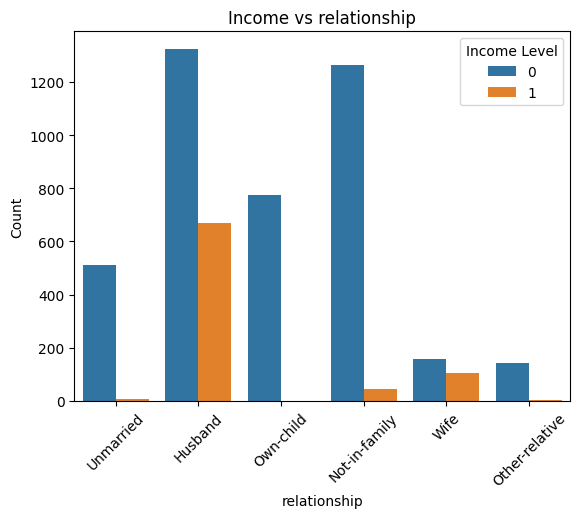

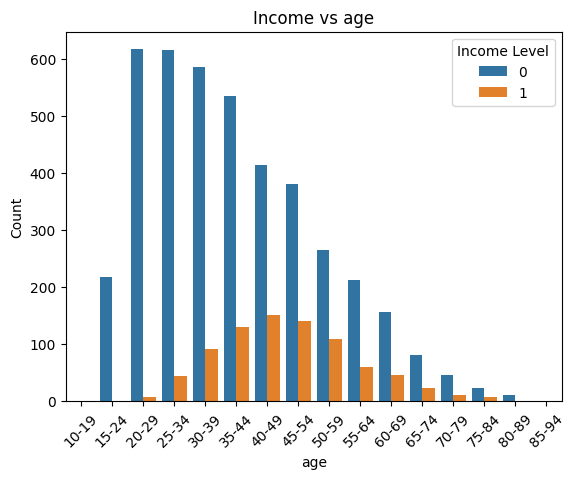

In [23]:

# for col in X_test_pred.columns    :
#     dominant_value = X_test_pred[col].mode()[0]
#     X_test_pred[col] = X_test_pred[col].fillna(dominant_value)


cols = ["occupation","marital-status","relationship"]
for col in cols:
    sns.countplot(data = X_test_combine, x = col, hue = "predicted_income")
    plt.title(f"Income vs {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Income Level")
    plt.show()

bins   = list(range(10, 91, 5))     
labels = [f"{b}-{b+9}" for b in bins[:-1]]
X_test_combine['age_binned'] = pd.cut(X_test_combine['age'], labels= labels, right = False, bins = bins)
sns.countplot(data = X_test_combine, x = 'age_binned', hue = "predicted_income")
plt.title("Income vs age")
plt.xlabel('age')
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Income Level")
plt.show()

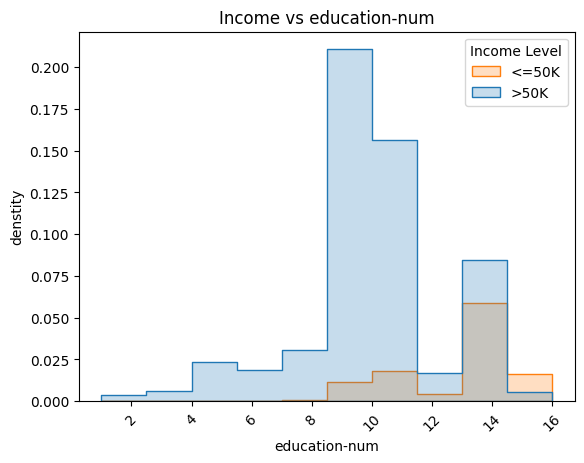

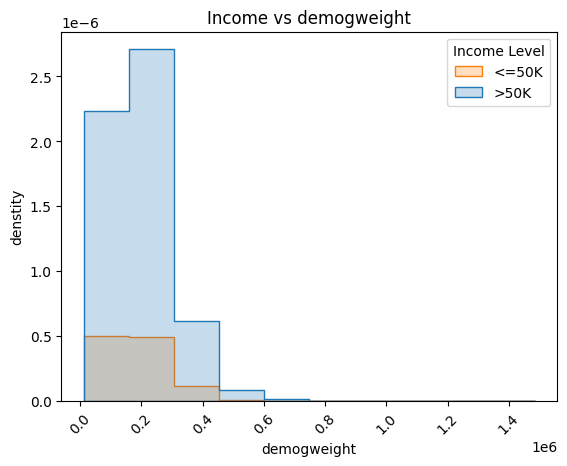

In [27]:
cols = ["education-num","demogweight"]
for col in cols:
    sns.histplot(data = X_test_combine, x = col, hue = "predicted_income", kde =False, stat = "density", element = "step", bins=10)
    plt.title(f"Income vs {col}")
    plt.xlabel(col)
    plt.ylabel("denstity")
    plt.xticks(rotation=45)
    plt.legend(title="Income Level", labels = ['<=50K', '>50K'])
    plt.show()

